<a href="https://colab.research.google.com/github/Vedant-cloud-ctrl/Quantium/blob/main/Quantium_Task_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [124]:
from google.colab import files
upload = files.upload()

Saving QVI_data.csv to QVI_data (4).csv


In [125]:
import pandas as pd
import numpy as np
import io

In [127]:
df = pd.read_csv(io.BytesIO(upload["QVI_data (4).csv"]))
df["DATE"] = pd.to_datetime(df["DATE"], dayfirst=True)
df["YEARMONTH"] = df["DATE"].dt.strftime("%Y%m").astype(int)
df.head()

<ipython-input-127-2753384713>:2: UserWarning: Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df["DATE"] = pd.to_datetime(df["DATE"], dayfirst=True)


,LYLTY_CARD_NBR,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER,YEARMONTH
0,1000,2018-10-17,1,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,NATURAL,YOUNG SINGLES/COUPLES,Premium,201810
1,1002,2018-09-16,1,2,58,Red Rock Deli Chikn&Garlic Aioli 150g,1,2.7,150,RRD,YOUNG SINGLES/COUPLES,Mainstream,201809
2,1003,2019-03-07,1,3,52,Grain Waves Sour Cream&Chives 210G,1,3.6,210,GRNWVES,YOUNG FAMILIES,Budget,201903
3,1003,2019-03-08,1,4,106,Natural ChipCo Hony Soy Chckn175g,1,3.0,175,NATURAL,YOUNG FAMILIES,Budget,201903
4,1004,2018-11-02,1,5,96,WW Original Stacked Chips 160g,1,1.9,160,WOOLWORTHS,OLDER SINGLES/COUPLES,Mainstream,201811




Select control store

The client has selected the stores 77, 86, 88 which was performe and wants the control stores to be established one.

We'll compare trial store to control store that are similar to the trial prior to trial period of Feb 2019

This can be broken down:

    monthly sales revenue
    monthly number of customers
    average number of transactions per customer



In [128]:
# Create monthly_metrics
monthly_metrics = df.groupby(["STORE_NBR", "YEARMONTH"]).agg(
    tot_sales = ("TOT_SALES", "sum"),
    num_customer = ("LYLTY_CARD_NBR", pd.Series.nunique),
    num_transaction = ("TXN_ID", pd.Series.nunique)
)
monthly_metrics["avg_num_transaction_per_customer"] = monthly_metrics["num_transaction"] / monthly_metrics["num_customer"]
monthly_metrics.reset_index(inplace=True)
monthly_metrics.head()

,STORE_NBR,YEARMONTH,tot_sales,num_customer,num_transaction,avg_num_transaction_per_customer
0,1,201807,206.9,49,52,1.061224
1,1,201808,176.1,42,43,1.023810
2,1,201809,278.8,59,62,1.050847
3,1,201810,188.1,44,45,1.022727
4,1,201811,192.6,46,47,1.021739


In [129]:
# Count num of months(rows) for each store
store_counts = monthly_metrics.groupby("STORE_NBR")["YEARMONTH"].nunique()

# Filter the data in 12 months
store_obs = store_counts[store_counts == 12].index.tolist()

# Create pre_trial_store with full obs
pre_trial_store = monthly_metrics[
    (monthly_metrics["YEARMONTH"] < 201902) &
    (monthly_metrics["STORE_NBR"].isin(store_obs))
].copy()
pre_trial_store.head()

,STORE_NBR,YEARMONTH,tot_sales,num_customer,num_transaction,avg_num_transaction_per_customer
0,1,201807,206.9,49,52,1.061224
1,1,201808,176.1,42,43,1.023810
2,1,201809,278.8,59,62,1.050847
3,1,201810,188.1,44,45,1.022727
4,1,201811,192.6,46,47,1.021739




Now we need to compare each control store to trial store and find how similar each potential control store is to its trial store. We can calculate how correlated the performance of each store to it trial ones.

We'll Create Correlation function


In [130]:
def cal_corr(df, metric_col, trial_store):
  store_numbers = df["STORE_NBR"].unique()
  trial_data = df[df["STORE_NBR"] == trial_store].sort_values("YEARMONTH")
  corr_list = []

  for store in store_numbers:
    compare_data = df[df["STORE_NBR"] == store].sort_values("YEARMONTH")

    merged = pd.merge(
        trial_data[["YEARMONTH", metric_col]],
        compare_data[["YEARMONTH", metric_col]],
        on="YEARMONTH",
        suffixes=("_trial", "_compare")
    )

    x = merged[f"{metric_col}_trial"]
    y  = merged[f"{metric_col}_compare"]

    if len(merged) >= 2 and x.nunique() > 1 and y.nunique() > 1:
      corr = np.corrcoef(x, y)[0, 1]
    else:
      corr = np.nan

    corr_list.append({
        "Store1": trial_store,
        "Store2": store,
        "corr_measures":corr
    })

  return pd.DataFrame(corr_list)

In [131]:
# Call pre_trial_store
pre_trial_store = monthly_metrics[
    (monthly_metrics["YEARMONTH"] < 201902) &
    (monthly_metrics["STORE_NBR"].isin(store_obs))
].copy()

# Select trial store 77
trial_store = 77

# Correlation of total sales
corr_nSales = cal_corr(pre_trial_store, "tot_sales", trial_store)

# Correlation of number of customer
corr_nCustomer = cal_corr(pre_trial_store, "num_customer", trial_store)

In [132]:
# Correlation of total sales
corr_nSales = cal_corr(pre_trial_store, "tot_sales", trial_store)

# Correlation of number of customer
corr_nCustomer = cal_corr(pre_trial_store, "num_customer", trial_store)

# Merged to get avg corr score
combined_corr = pd.merge(
    corr_nSales,
    corr_nCustomer,
    on="Store2",
    suffixes=("_nSales", "_nCustomer")
)

combined_corr["corr_score"] = (
    combined_corr["corr_measures_nSales"] + combined_corr["corr_measures_nCustomer"]
)/2

# Sort by most similar store (excluding trial_store itself)
top_matches = combined_corr[combined_corr["Store2"] != trial_store]
top_matches = top_matches.sort_values("corr_score", ascending=False)
top_matches.head()

,Store1_nSales,Store2,corr_measures_nSales,Store1_nCustomer,corr_measures_nCustomer,corr_score
221,77,233,0.903774,77,0.990358,0.947066
111,77,119,0.867664,77,0.983267,0.925466
67,77,71,0.914106,77,0.754817,0.834461
2,77,3,0.806644,77,0.834207,0.820426
38,77,41,0.783232,77,0.844219,0.813726


We'll create function for magntiude distance.

In [133]:
def cal_magnitude_dist(df, metric_col, trial_store):
  cal_dist_list = []

  # Get unique store numbers except the trial store
  store_numbers = df["STORE_NBR"].unique()

  # Get trial store data
  trial_data = df[df["STORE_NBR"] == trial_store][["YEARMONTH", metric_col]].sort_values("YEARMONTH")

  for store in store_numbers:
    if store == trial_store:
      continue

    control_data = df[df["STORE_NBR"] == store][["YEARMONTH", metric_col]].sort_values("YEARMONTH")

    # Megre on MONTH to ensure same time periods
    merged = pd.merge(
        trial_data,
        control_data,
        on = "YEARMONTH",
        suffixes = ("_trial", "_control")
    )

    # Calculate absolute distance
    merged["measure"] = (merged[f"{metric_col}_trial"] - merged[f"{metric_col}_control"]).abs()

    # Add indentifiers
    merged["Store1"] = trial_store
    merged["Store2"] = store

    cal_dist_list.append(merged[["Store1", "Store2", "YEARMONTH", "measure"]])

  # Combine all results
  cal_dist_df = pd.concat(cal_dist_list, ignore_index=True)

  # Standardize the measure:
  minmax = cal_dist_df.groupby(["Store1", "YEARMONTH"])["measure"].agg(["min", "max"]).reset_index()
  minmax = minmax.rename(columns={"min": "minDist", "max":"maxDist"})

  # Merge min-max
  dist_df = pd.merge(cal_dist_df, minmax, on=["Store1", "YEARMONTH"], how="left")

  # Avoid divide by zero
  dist_df["magnitudeMeasure"] = 1 - ((dist_df["measure"] - dist_df["minDist"]) /
                                     (dist_df["maxDist"] - dist_df["minDist"]).replace(0, np.nan))
  dist_df["magnitudeMeasure"] = dist_df["magnitudeMeasure"].fillna(0)

  # Final aggregated distance store per Store1 and Store2
  final_df = dist_df.groupby(["Store1", "Store2"])["magnitudeMeasure"].mean().reset_index()
  final_df = final_df.rename(columns={"magnitudeMeasure": "mag_measure"})

  return final_df

In [134]:
magnitude_nSales = cal_magnitude_dist(pre_trial_store, "tot_sales", trial_store=77)
magnitude_nCustomer = cal_magnitude_dist(pre_trial_store, "num_customer", trial_store=77)

In [135]:
# Combinig both measures
combined_mag = pd.merge(
    magnitude_nSales,
    magnitude_nCustomer,
    on=["Store1", "Store2"],
    suffixes=("_sales", "_customers")
)
combined_mag["mag_score"] = (combined_mag["mag_measure_sales"] + combined_mag["mag_measure_customers"])/2

# Top 10
combined_mag.sort_values("mag_score", ascending=False).head(10)

,Store1,Store2,mag_measure_sales,mag_measure_customers,mag_score
220,77,233,0.987091,0.992773,0.989932
38,77,41,0.966917,0.974639,0.970778
42,77,46,0.976565,0.960757,0.968661
49,77,53,0.977210,0.957763,0.967487
103,77,111,0.967254,0.966064,0.966659
179,77,188,0.976961,0.943943,0.960452
195,77,205,0.974154,0.939139,0.956647
251,77,265,0.964439,0.947902,0.956170
5,77,6,0.971068,0.939620,0.955344
158,77,167,0.960916,0.949349,0.955133


In [136]:
# Define corr weight
corr_weight = 0.5

# Merge correlation and magnitude distance for nSales
score_nSales = pd.merge(
    corr_nSales,
    magnitude_nSales,
    on=["Store1", "Store2"]
)
score_nSales["scoreNSales"] = (
    score_nSales["corr_measures"] * corr_weight +
    score_nSales["mag_measure"] * (1 - corr_weight)
)

# Merge correlation and magnitude distance for nCustomer
score_nCust = pd.merge(
    corr_nCustomer,
    magnitude_nCustomer,
    on=["Store1", "Store2"]
)
score_nCust["scoreNCust"] = (
    score_nCust["corr_measures"] * corr_weight +
    score_nCust["mag_measure"] * (1 - corr_weight)
)

# Combined score across both drivers
score_Control = pd.merge(score_nSales, score_nCust, on=["Store1", "Store2"])
score_Control["final_score"] = (
    score_Control["scoreNSales"] * 0.5 +
    score_Control["scoreNCust"] * 0.5
)

# Select control store for trial_store
trial_store = 77
filtered_scores = score_Control[score_Control["Store1"] == trial_store]
sorted_scores = filtered_scores.sort_values(by="final_score", ascending=False)

# Select the second-highest matching store
control_store = sorted_scores.iloc[0]["Store2"]
print(control_store)

233.0


We found the contorl store which is 233

In [137]:
import seaborn as sns
import matplotlib.pyplot as plt

# TOTAL SALES BY MONTH

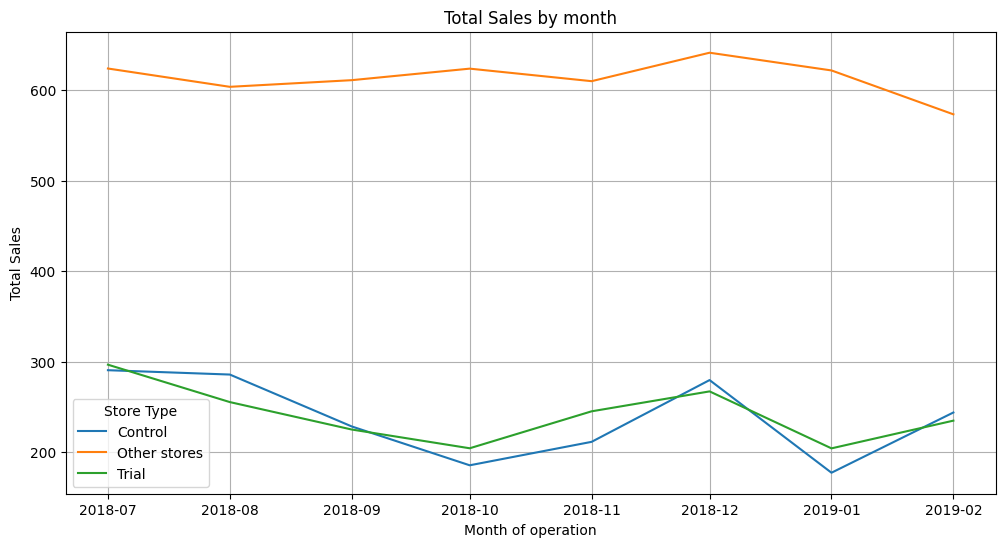

In [138]:
trial_store = 77
control_store = 233
monthly_metrics = monthly_metrics.copy()

# Label store type
monthly_metrics["Store_type"] = monthly_metrics["STORE_NBR"].apply(
    lambda x: "Trial" if x == trial_store else
              "Control" if x == control_store else
              "Other stores"
)

# Group by YEARMONTH and Store_type to get mean sales
pastSales = monthly_metrics.groupby(["YEARMONTH", "Store_type"], as_index=False)["tot_sales"].mean()

# Create a proper date for plotting (1st day of each month)
pastSales["TransactionMonth"] = pd.to_datetime(
    pastSales["YEARMONTH"].astype(str).str[:4] + "-" +
    pastSales["YEARMONTH"].astype(str).str[4:] + "-01"
)

# Filter months before March 2019
pastSales = pastSales[pastSales["YEARMONTH"] < 201903]

# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=pastSales, x="TransactionMonth", y="tot_sales", hue="Store_type")

# Customize plot
plt.title("Total Sales by month")
plt.xlabel("Month of operation")
plt.ylabel("Total Sales")
plt.legend(title="Store Type")
plt.grid(True)
plt.show()

The line plot titled "Total Sales by month" shows the monthly total sales trends from July 2018 to February 2019 for three store types:

1. Other stores (orange line):
* Consistently the highest sales across all months.  
* Sales fluctuate slightly, peaking around December 2018 and then declining towards February 2019.

2. Control stores (blue line):
* Start close to Trial stores in July 2018.  
* Exhibit a dip around October 2018, followed by a rise in December 2018, then drop again in January 2019.
* A slight recovery in February 2019.

3. Trial stores (green line)::
* Similar trend to Control stores with a small lag or shift.  
* Lowest point is in October 2018, improves until December 2018, dips in January, and rises again in February 2019.

Summary:
* Other stores consistently outperform both Control and Trial stores.
* Control and Trial stores show similar sales patterns, suggesting a possible relationship or comparable influence.
* Seasonal effects may be evident, with December seeing a peak for all three types—possibly due to holiday season sales.


# TOTAL NUMBER OF CUSTOMER

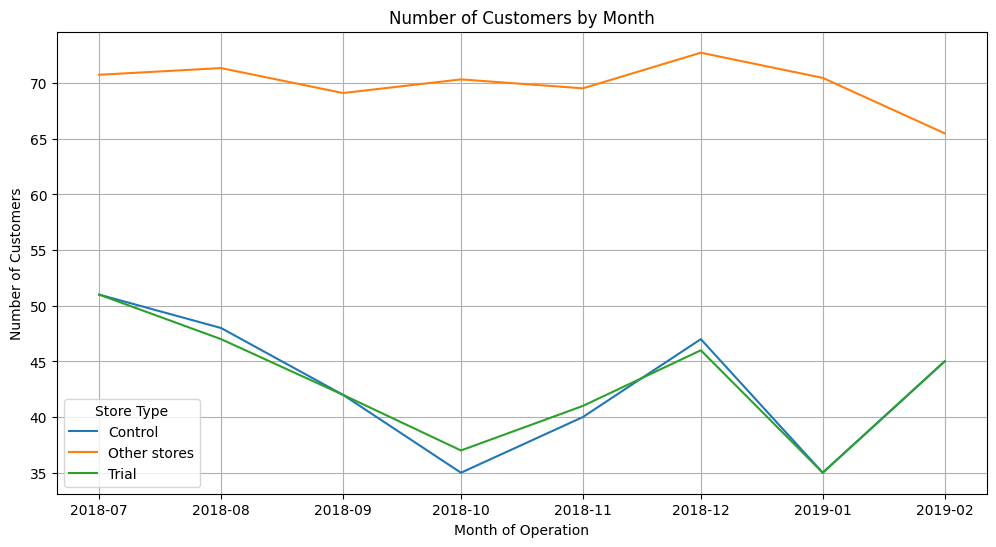

In [139]:
trial_store = 77
control_store = 233
monthly_metrics = monthly_metrics.copy()

# Label store type
monthly_metrics["Store_type"] = monthly_metrics["STORE_NBR"].apply(
    lambda x: "Trial" if x == trial_store else
              "Control" if x == control_store else
              "Other stores"
)

# Group by YEARMONTH and Store_type to get mean of num_customers
pastCust = monthly_metrics.groupby(["YEARMONTH", "Store_type"], as_index=False)["num_customer"].mean()

# Create a proper date for plotting (1st day of each month)
pastCust["TransactionMonth"] = pd.to_datetime(
    pastCust["YEARMONTH"].astype(str).str[:4] + "-" +
    pastCust["YEARMONTH"].astype(str).str[4:] + "-01"
)

# Filter months before March 2019
pastCust = pastCust[pastCust["YEARMONTH"] < 201903]

# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=pastCust, x="TransactionMonth", y="num_customer", hue="Store_type")

# Customize Plot
plt.title("Number of Customers by Month")
plt.xlabel("Month of Operation")
plt.ylabel("Number of Customers")
plt.legend(title="Store Type")
plt.grid(True)
plt.show()

The line plot titled "Number of Customers by Month" shows the monthly customer count from July 2018 to February 2019 across three types of stores:

1. Other stores (orange line):
* Consistently the highest customer count among all store types.  
* Fairly stable with only slight fluctuations.
* Peaks in December 2018, drops off in February 2019.

2. Control stores (blue line):
* Begins around 50 customers in July 2018.  
* Shows a gradual decline until October 2018, followed by a recovery in November and December.
* Customer count dips again in January 2019, then slightly recovers in February.

3. Trial stores (green line):
* Mirrors the trend of the Control stores closely.  
* Lowest point also in October 2018, with an upward trend in
November - December.
* Dips again in January 2019, rises back in February.

Summary:
* Other stores consistently attract more customers and maintain stability.
* Trial and Control stores experience similar customer trends, suggesting similar influencing factors.
* Seasonal trend visible: a peak in December (likely holiday season), followed by a January drop and February recovery.


In [140]:
# Calculate the scaling factor for control store sales
trial_sales_sum = pre_trial_store[
    (pre_trial_store["STORE_NBR"] == trial_store) &
    (pre_trial_store["YEARMONTH"] < 201902)
]["tot_sales"].sum()

control_sales_sum = pre_trial_store[
    (pre_trial_store["STORE_NBR"] == control_store) &
    (pre_trial_store["YEARMONTH"] < 201902)
]["tot_sales"].sum()

scalingFactorForControlSales = trial_sales_sum / control_sales_sum

# Apply scaling factor to the control store in monthly_metrics
monthly_metrics = monthly_metrics.copy()

# Create a new column 'controlSales' with scaled sales only for control store
monthly_metrics["controlSales"] = monthly_metrics.apply(
    lambda row: row["tot_sales"] * scalingFactorForControlSales
    if row["STORE_NBR"] == control_store else None,
    axis=1
)

In [141]:
# Get scaled control sales
scaledControlSales = monthly_metrics[
    (monthly_metrics["STORE_NBR"] == control_store)
][["YEARMONTH", "controlSales"]].copy()

# Get trial store sales
trialSales = monthly_metrics[
    (monthly_metrics["STORE_NBR"] == trial_store)
][["YEARMONTH", "tot_sales"]].copy()

# Merge on YEARMONTH
percentageDiff = pd.merge(scaledControlSales, trialSales, on="YEARMONTH")

# Calculate percentage diff
percentageDiff["percentageDiff"] = (
    abs(percentageDiff["controlSales"] - percentageDiff["tot_sales"]) / percentageDiff["controlSales"]
)

# Format as percenatge
percentageDiff["percentageDiff"] = percentageDiff["percentageDiff"] * 100

# Preview result
print(percentageDiff[["YEARMONTH", "controlSales", "tot_sales", "percentageDiff"]])

    YEARMONTH  controlSales  tot_sales  percentageDiff
0      201807    297.565550      296.8        0.257271
1      201808    292.652187      255.5       12.694997
2      201809    233.998916      225.2        3.760238
3      201810    190.085733      204.5        7.583035
4      201811    216.597421      245.3       13.251579
5      201812    286.408121      267.3        6.671641
6      201901    181.692071      204.4       12.498029
7      201902    249.762622      235.0        5.910661
8      201903    203.802205      278.5       36.652103
9      201904    162.345704      263.5       62.307960
10     201905    352.533799      299.3       15.100339
11     201906    226.219424      264.7       17.010288


# Summary of Sales Impact Analysis :

**Pre-Trial Period (Before 201902)**

| YEARMONTH       | Avg % Difference |
| --------------- | ---------------- |
| 201807 - 201901 | \~**8.23%**      |



* Sales levels between the trial and scaled control stores are reasonably close
* Confirms that the scaling factor worked effectively.
* Validates the control store as a good synthetic baseline.

**Trial Period (201902 Onward)**

| YEARMONTH | % Difference |
| --------- | ------------ |
| 201902    | 5.91%        |
| 201903    | 36.65%       |
| 201904    | 62.31%       |
| 201905    | 15.10%       |
| 201906    | 17.01%       |
| **Avg**   | **27.80%**   |

* Spike observed starting March 2019, especially:
  * March - April with >35% to 60% increase in trial store vs control
* Suggests a strong positive effect from the intervention.
* Percentage differences are significantly higher than pre-trial variation.

**Interpretation**

The intervention in the trial store likely drove a substantial lift in sales, particularly from March to April 2019, where deviations from expected behavior peaked.

Moving Further and Check if there is siginificant differnce.

In [142]:
# To determine if the observed percentage differnece during the the trial months(Feb to Apr 2019) are statistically significan, given the normal variation in the pre-trial period.
# There's no significant diff between the trial stores and control stores - i.e., the trial behave the same as the pre-trial period
stdDev = percentageDiff[percentageDiff["YEARMONTH"] < 201902]["percentageDiff"].std(ddof=1)

# Note that the pre-trial-period has 8 months
# hence 8 - 1 = 7 which is degree of freedom
degree_of_freedom = 7

# For each trial month (201902–201904):
trial_tvalues = percentageDiff[
    (percentageDiff["YEARMONTH"] > 201901) &
    (percentageDiff["YEARMONTH"] < 201905)
].copy()

trial_tvalues["t_value" ] = trial_tvalues["percentageDiff"] / stdDev

# Convert YEARMONTH to datetime for plotting or display:
trial_tvalues["TransactionMonth"] = pd.to_datetime(
    trial_tvalues["YEARMONTH"].astype(str) + "01", format = "%Y%M%d"
)
print(trial_tvalues[["TransactionMonth", "t_value"]])

     TransactionMonth    t_value
7 2019-01-01 00:02:00   1.183534
8 2019-01-01 00:03:00   7.339116
9 2019-01-01 00:04:00  12.476373


In [143]:
from scipy.stats import t

# Degree of freedom
degree_of_freedom = 7

# 95th percentile critical value for one-tailed t-test
critical_t = t.ppf(0.95, df=degree_of_freedom)

print(critical_t)

1.894578605061305


# t-Value Analysis (Trial Period vs Pre Trial Period)

| Month    | t-Value | Comparison to Critical t (1.895) | Conclusion          |
| -------- | ------- | -------------------------------- | ------------------- |
| Feb 2019 | 1.18    | Less than 1.895                  | **Not significant** |
| Mar 2019 | 7.34    | Greater than 1.895               | **Significant**     |
| Apr 2019 | 12.48   | Greater than 1.895               | **Significant**     |

**Interpretation:**
* Only February 2019 shows no statistically significant difference between the trial and control stores.
* March and April 2019 show significant deviation, meaning the trial intervention likely had an impact on sales during those months.



Let's take it further and create visualize plot to control store, trial store and 95th percentile value of stores of the control store

**Total Sales by Month**

This line chart visualizes monthly average total sales for Trial and Control stores, including confidence intervals and highlighting the trial intervention period from February to April 2019.

**Interpretation & Insights:**
* Before the trial period (July 2018 - Jan 2019):
  * Trial and Control stores had similar sales trends, indicating a reasonable baseline comparison.

* During the trial period (Feb 2019 - Apr 2019):
  * Trial store sales exceeded the 95th percentile confidence interval of the Control group.



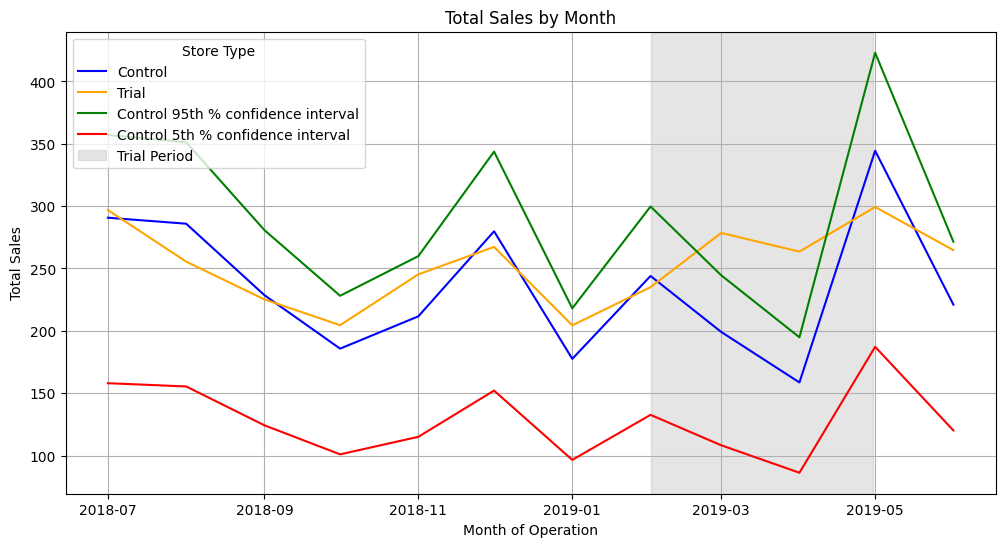

In [144]:
# Add store type
monthly_metrics["Store_type"] = monthly_metrics["STORE_NBR"].apply(
    lambda x: "Trial" if x == trial_store else
              ("Control" if x == control_store else "Other")
)

# Agg avg monthly sales
pastSales = monthly_metrics.groupby(["YEARMONTH", "Store_type"]).agg(
    totSales = ("tot_sales", "mean")
).reset_index()

# Add transaction month
pastSales["TransactionMonth"] = pd.to_datetime(
    pastSales["YEARMONTH"].astype(str) + "01", format="%Y%m%d"
)

# Filter trial and control only
trial_control_sales = pastSales[pastSales["Store_type"].isin(["Trial", "Control"])]

trial_sales = trial_control_sales[trial_control_sales["Store_type"] == "Trial"].reset_index(drop=True)
control_sales = trial_control_sales[trial_control_sales["Store_type"] == "Control"].reset_index(drop=True)
percentageDiff = (trial_sales["totSales"] - control_sales["totSales"]) / control_sales["totSales"]

# Compute standard deviation of percentage diff
stdDev = percentageDiff.std()

# Upper bound (95th percentile)
upper = control_sales.copy()
upper["totSales"] = control_sales["totSales"] * (1 + stdDev)
upper["Store_type"] = "Control 95th % confidence interval"
upper["TransactionMonth"] = control_sales["TransactionMonth"]

# Lower bound (5th percentile)
lower = control_sales.copy()
lower["totSales"] = control_sales["totSales"] * (1 - stdDev * 2)
lower["Store_type"] = "Control 5th % confidence interval"
lower["TransactionMonth"] = control_sales["TransactionMonth"]

# Combine all
trial_assessment = pd.concat([trial_control_sales, upper, lower])
trial_assessment = trial_assessment.loc[:, ~trial_assessment.columns.duplicated()]

# Defibe custom color palette
palette = {
    "Control":"blue",
    "Trial":"orange",
    "Control 95th % confidence interval": "green",
    "Control 5th % confidence interval" : "red"
}

# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=trial_assessment, x="TransactionMonth", y="totSales", hue="Store_type", palette=palette)

# Shade trial period (Feb-Apr 2019)
plt.axvspan(pd.to_datetime("2019-02-01"), pd.to_datetime("2019-04-30"),
            color="grey", alpha=0.2, label="Trial Period")

# Labels and Title
plt.title("Total Sales by Month")
plt.xlabel("Month of Operation")
plt.ylabel("Total Sales")
plt.legend(title="Store Type")
plt.grid(True)
plt.show()

**Total Sales by Month**

This time series line plot compares total monthly sales of two store types Control and Trial along with confidence intervals for the Control store. Here's a breakdown

**Time Frame:**
*  From: July 2018
*  To: June 2019
*  Shaded Period (Feb - Apr 2019): Represents the Trial Period

**Observation**
*  During the trial period (Feb - Apr 2019), the Trial store's sales consistently stayed above the Control store's 95th percentile band, especially in Feb and Mar.
   * This indicates a statistically significant increase in sales at the Trial store.
*  Outside the trial period, Trial and Control sales trends mostly follow a similar seasonal pattern, though with variation.
*  The Control confidence interval (green and red lines) helps visualize the range of expected sales variability. The Trial store's performance exceeding this band suggests a positive impact from the trial intervention.

**Final Insights:**
The results show that the trial in store 77 is significantly different to its control store in the trial period as the trial store performance lies outside the 5% to 95% confidence interval of the control store in two of the three trial months.

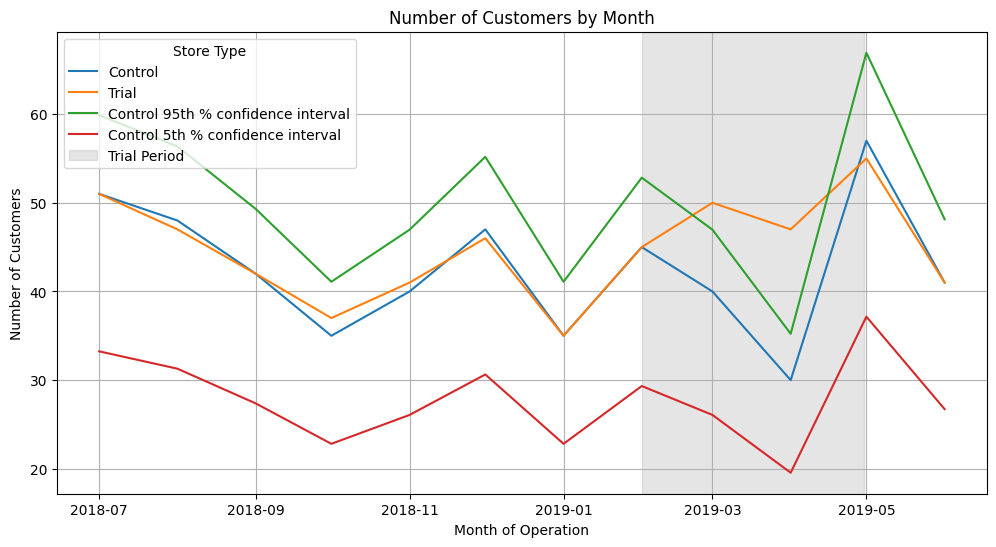

In [145]:
# We'll plot for customers
# Add store type
monthly_metrics["Store_type"] = monthly_metrics["STORE_NBR"].apply(
    lambda x: "Trial" if x == trial_store else
    ("Control" if x == control_store else "Other")
)

# Aggergate avg monthly number of customers
pastCust = monthly_metrics.groupby(["YEARMONTH", "Store_type"]).agg(
    numCust = ("num_customer", "mean")
).reset_index()

# Add transaction month
pastCust["TransactionMonth"] = pd.to_datetime(
    pastCust["YEARMONTH"].astype(str) + "01", format="%Y%m%d"
)

# Filter trial and control only
trial_control_customer = pastCust[pastCust["Store_type"].isin(["Trial", "Control"])]

trial_cust = trial_control_customer[trial_control_customer["Store_type"] == "Trial"].reset_index(drop=True)
control_cust = trial_control_customer[trial_control_customer["Store_type"] == "Control"].reset_index(drop=True)
perecentageDiff = (trial_cust["numCust"] - control_cust["numCust"]) / control_cust["numCust"]

# Compute standard deviation of percentage diff
stdDev = perecentageDiff.std()

# Upper bound (95th percentile)
upper_bound = control_cust.copy()
upper_bound["numCust"] = control_cust["numCust"] * (1 + stdDev)
upper_bound["Store_type"] = "Control 95th % confidence interval"
upper_bound["TransactionMonth"] = control_cust["TransactionMonth"]

# Lower bound (5th percentile)
lower_bound = control_cust.copy()
lower_bound["numCust"] = control_cust["numCust"] * (1 - stdDev * 2)
lower_bound["Store_type"] = "Control 5th % confidence interval"
lower_bound["TransactionMonth"] = control_cust["TransactionMonth"]

# Combine all
trial_assessment = pd.concat([trial_control_customer, upper_bound, lower_bound])
trial_assessment = trial_assessment.loc[:, ~trial_assessment.columns.duplicated()]

# Define custome color palette
palette = {
    "Control":"blue",
    "Trial":"orange",
    "Control 95th % confidence interval": "green",
    "Control 5th % confidence interval" : "red"
}

# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=trial_assessment, x="TransactionMonth", y="numCust", hue="Store_type")

# Shade trial period
plt.axvspan(pd.to_datetime("2019-02-01"), pd.to_datetime("2019-04-30"),
            color="grey", alpha=0.2, label="Trial Period")

# Labels and title
plt.title("Number of Customers by Month")
plt.xlabel("Month of Operation")
plt.ylabel("Number of Customers")
plt.grid(True)
plt.legend(title="Store Type")

# Trial Store 86

In [146]:
# Call pre_trial_store
pre_trial_store = monthly_metrics[
    (monthly_metrics["YEARMONTH"] < 201902) &
    (monthly_metrics["STORE_NBR"].isin(store_obs))
].copy()

# Select trial store
trial_store = 86

# Correlation of total sales
corr_nSales = cal_corr(pre_trial_store, "tot_sales", trial_store)

# Correlation of number of customer
corr_nCustomer = cal_corr(pre_trial_store, "num_customer", trial_store)

In [147]:
# Correlation of total sales
corr_nSales = cal_corr(pre_trial_store, "tot_sales", trial_store)

# Correlation of number of customer
corr_nCustomer = cal_corr(pre_trial_store, "num_customer", trial_store)

# Merged to get avg corr score
combined_corr = pd.merge(
    corr_nSales,
    corr_nCustomer,
    on="Store2",
    suffixes=("_nSales", "_nCustomer")
)

combined_corr["corr_score"] = (
    combined_corr["corr_measures_nSales"] + combined_corr["corr_measures_nCustomer"]
)/2

# Sort by most similar store (excluding trial_store itself)
top_matches = combined_corr[combined_corr["Store2"] != trial_store]
top_matches = top_matches.sort_values("corr_score", ascending=False)
top_matches.head()

,Store1_nSales,Store2,corr_measures_nSales,Store1_nCustomer,corr_measures_nCustomer,corr_score
147,86,155,0.877882,86,0.942876,0.910379
107,86,114,0.734415,86,0.855339,0.794877
247,86,260,0.720350,86,0.846502,0.783426
102,86,109,0.788300,86,0.770778,0.779539
130,86,138,0.759864,86,0.749701,0.754782


In [148]:
magnitude_nSales = cal_magnitude_dist(pre_trial_store, "tot_sales", trial_store=86)
magnitude_nCustomer = cal_magnitude_dist(pre_trial_store, "num_customer", trial_store=86)

In [149]:
# Combinig both measures
combined_mag = pd.merge(
    magnitude_nSales,
    magnitude_nCustomer,
    on=["Store1", "Store2"],
    suffixes=("_sales", "_customers")
)
combined_mag["mag_score"] = (combined_mag["mag_measure_sales"] + combined_mag["mag_measure_customers"])/2

# Top 10
combined_mag.sort_values("mag_score", ascending=False).head(10)

,Store1,Store2,mag_measure_sales,mag_measure_customers,mag_score
146,86,155,0.964782,0.985037,0.974909
101,86,109,0.963810,0.965940,0.964875
212,86,225,0.958060,0.967367,0.962713
216,86,229,0.950408,0.962017,0.956213
36,86,39,0.929158,0.959280,0.944219
234,86,247,0.934851,0.946897,0.940874
209,86,222,0.960861,0.920373,0.940617
93,86,101,0.935941,0.944723,0.940332
58,86,62,0.930540,0.947896,0.939218
9,86,10,0.941719,0.934378,0.938049


In [150]:
# Define corr weight
corr_weight = 0.5

# Merge correlation and magnitude distance for nSales
score_nSales = pd.merge(
    corr_nSales,
    magnitude_nSales,
    on=["Store1", "Store2"]
)
score_nSales["scoreNSales"] = (
    score_nSales["corr_measures"] * corr_weight +
    score_nSales["mag_measure"] * (1 - corr_weight)
)

# Merge correlation and magnitude distance for nCustomer
score_nCust = pd.merge(
    corr_nCustomer,
    magnitude_nCustomer,
    on=["Store1", "Store2"]
)
score_nCust["scoreNCust"] = (
    score_nCust["corr_measures"] * corr_weight +
    score_nCust["mag_measure"] * (1 - corr_weight)
)

# Combined score across both drivers
score_Control = pd.merge(score_nSales, score_nCust, on=["Store1", "Store2"])
score_Control["final_score"] = (
    score_Control["scoreNSales"] * 0.5 +
    score_Control["scoreNCust"] * 0.5
)

# Select control store for trial_store
trial_store = 86
filtered_scores = score_Control[score_Control["Store1"] == trial_store]
sorted_scores = filtered_scores.sort_values(by="final_score", ascending=False)

# Select matching store
control_store = sorted_scores.iloc[0]["Store2"]
print(control_store)

155.0


# Total Sales by Month

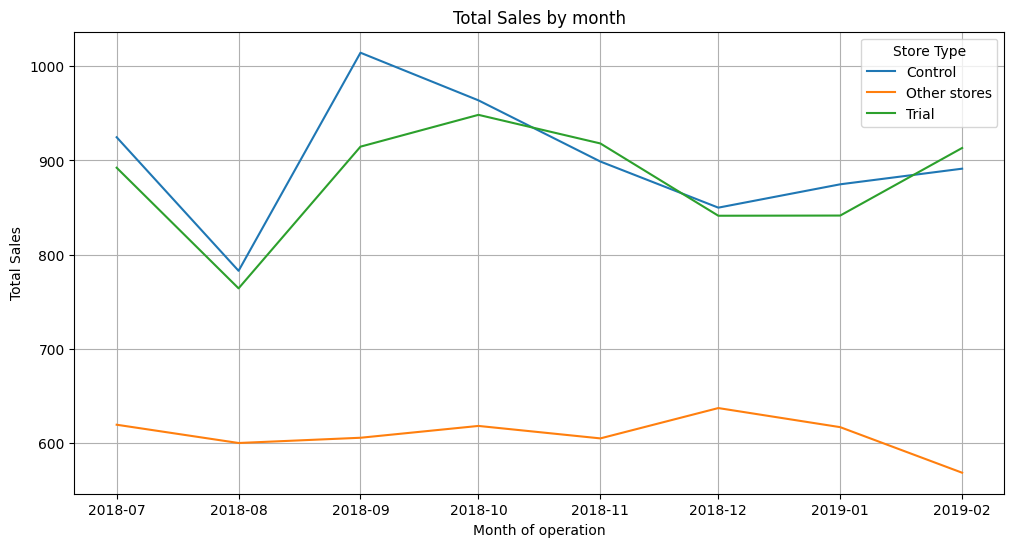

In [151]:
trial_store = 86
control_store = 155
monthly_metrics = monthly_metrics.copy()

# Label store type
monthly_metrics["Store_type"] = monthly_metrics["STORE_NBR"].apply(
    lambda x: "Trial" if x == trial_store else
              "Control" if x == control_store else
              "Other stores"
)

# Group by YEARMONTH and Store_type to get mean sales
pastSales = monthly_metrics.groupby(["YEARMONTH", "Store_type"], as_index=False)["tot_sales"].mean()

# Create a proper date for plotting (1st day of each month)
pastSales["TransactionMonth"] = pd.to_datetime(
    pastSales["YEARMONTH"].astype(str).str[:4] + "-" +
    pastSales["YEARMONTH"].astype(str).str[4:] + "-01"
)

# Filter months before March 2019
pastSales = pastSales[pastSales["YEARMONTH"] < 201903]

# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=pastSales, x="TransactionMonth", y="tot_sales", hue="Store_type")

# Customize plot
plt.title("Total Sales by month")
plt.xlabel("Month of operation")
plt.ylabel("Total Sales")
plt.legend(title="Store Type")
plt.grid(True)
plt.show()

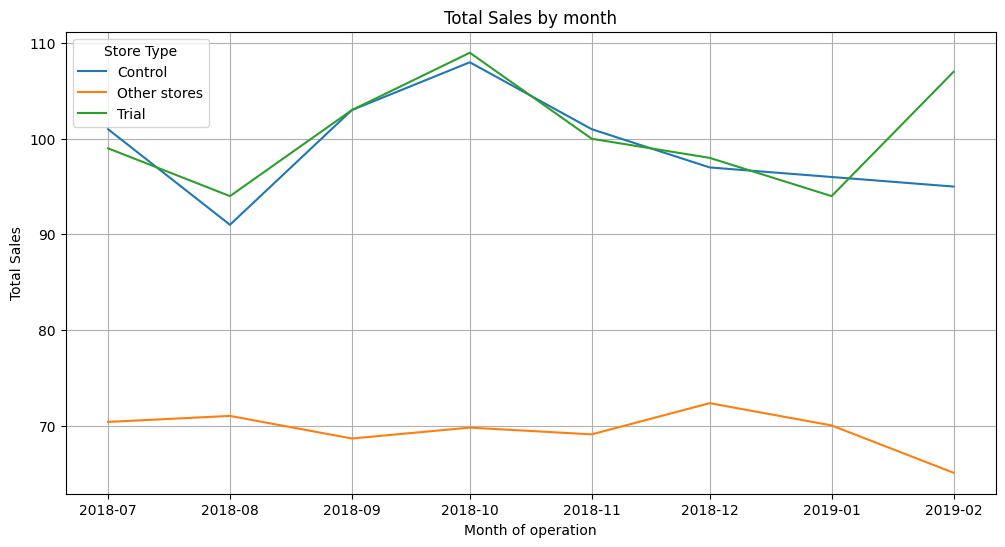

In [152]:
trial_store = 86
control_store = 155
monthly_metrics = monthly_metrics.copy()

# Label store type
monthly_metrics["Store_type"] = monthly_metrics["STORE_NBR"].apply(
    lambda x: "Trial" if x == trial_store else
              "Control" if x == control_store else
              "Other stores"
)

# Group by YEARMONTH and Store_type to get mean sales
pastCust = monthly_metrics.groupby(["YEARMONTH", "Store_type"], as_index=False)["num_customer"].mean()

# Create a proper date for plotting (1st day of each month)
pastCust["TransactionMonth"] = pd.to_datetime(
    pastCust["YEARMONTH"].astype(str).str[:4] + "-" +
    pastCust["YEARMONTH"].astype(str).str[4:] + "-01"
)

# Filter months before March 2019
pastCust = pastCust[pastCust["YEARMONTH"] < 201903]

# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=pastCust, x="TransactionMonth", y="num_customer", hue="Store_type")

# Customize plot
plt.title("Total Sales by month")
plt.xlabel("Month of operation")
plt.ylabel("Total Sales")
plt.legend(title="Store Type")
plt.grid(True)
plt.show()

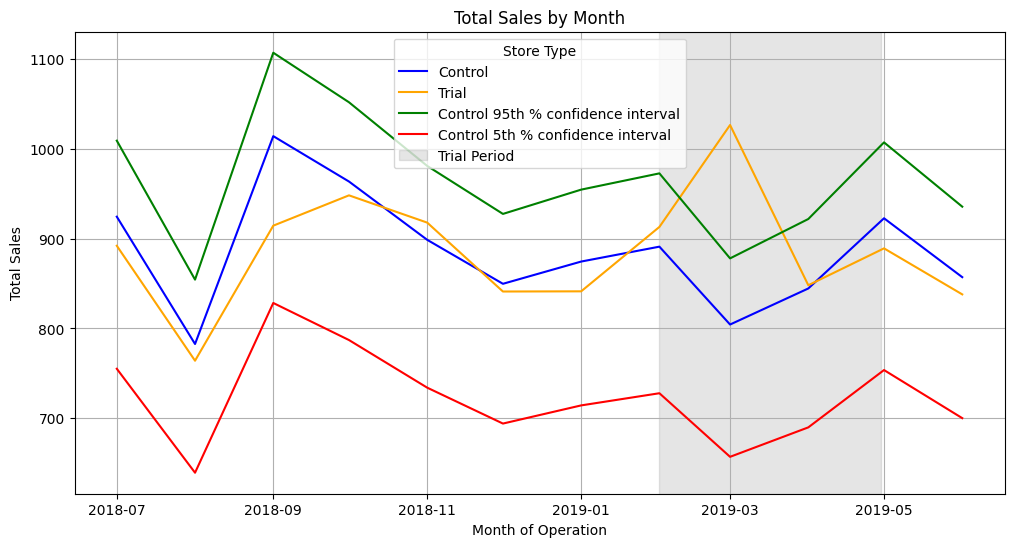

In [153]:
# Add store type
monthly_metrics["Store_type"] = monthly_metrics["STORE_NBR"].apply(
    lambda x: "Trial" if x == trial_store else
              ("Control" if x == control_store else "Other")
)

# Agg avg monthly sales
pastSales = monthly_metrics.groupby(["YEARMONTH", "Store_type"]).agg(
    totSales = ("tot_sales", "mean")
).reset_index()

# Add transaction month
pastSales["TransactionMonth"] = pd.to_datetime(
    pastSales["YEARMONTH"].astype(str) + "01", format="%Y%m%d"
)

# Filter trial and control only
trial_control_sales = pastSales[pastSales["Store_type"].isin(["Trial", "Control"])]

trial_sales = trial_control_sales[trial_control_sales["Store_type"] == "Trial"].reset_index(drop=True)
control_sales = trial_control_sales[trial_control_sales["Store_type"] == "Control"].reset_index(drop=True)
percentageDiff = (trial_sales["totSales"] - control_sales["totSales"]) / control_sales["totSales"]

# Compute standard deviation of percentage diff
stdDev = percentageDiff.std()

# Upper bound (95th percentile)
upper = control_sales.copy()
upper["totSales"] = control_sales["totSales"] * (1 + stdDev)
upper["Store_type"] = "Control 95th % confidence interval"
upper["TransactionMonth"] = control_sales["TransactionMonth"]

# Lower bound (5th percentile)
lower = control_sales.copy()
lower["totSales"] = control_sales["totSales"] * (1 - stdDev * 2)
lower["Store_type"] = "Control 5th % confidence interval"
lower["TransactionMonth"] = control_sales["TransactionMonth"]

# Combine all
trial_assessment = pd.concat([trial_control_sales, upper, lower])
trial_assessment = trial_assessment.loc[:, ~trial_assessment.columns.duplicated()]

# Defibe custom color palette
palette = {
    "Control":"blue",
    "Trial":"orange",
    "Control 95th % confidence interval": "green",
    "Control 5th % confidence interval" : "red"
}

# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=trial_assessment, x="TransactionMonth", y="totSales", hue="Store_type", palette=palette)

# Shade trial period (Feb-Apr 2019)
plt.axvspan(pd.to_datetime("2019-02-01"), pd.to_datetime("2019-04-30"),
            color="grey", alpha=0.2, label="Trial Period")

# Labels and Title
plt.title("Total Sales by Month")
plt.xlabel("Month of Operation")
plt.ylabel("Total Sales")
plt.legend(title="Store Type")
plt.grid(True)
plt.show()

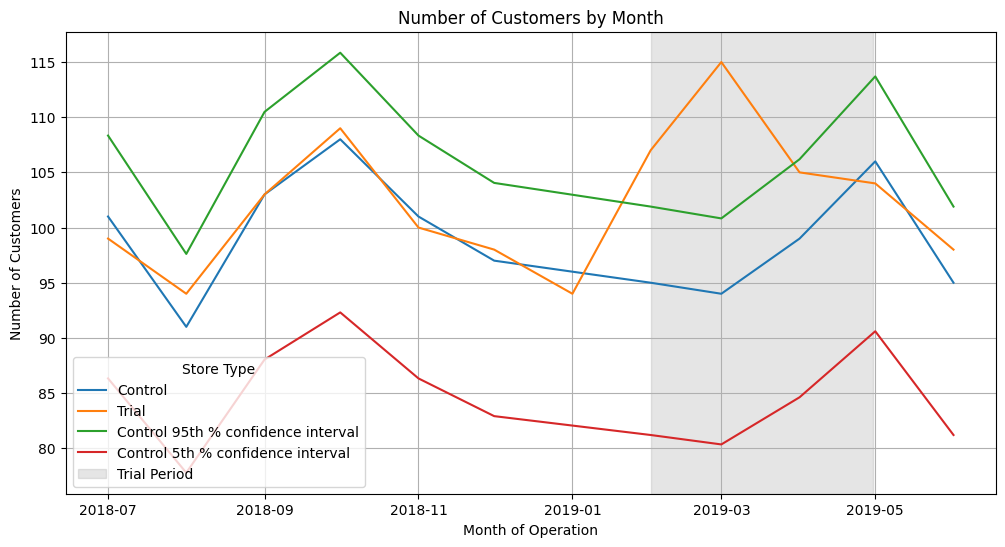

In [154]:
# We'll plot for customers
# Add store type
monthly_metrics["Store_type"] = monthly_metrics["STORE_NBR"].apply(
    lambda x: "Trial" if x == trial_store else
    ("Control" if x == control_store else "Other")
)

# Aggergate avg monthly number of customers
pastCust = monthly_metrics.groupby(["YEARMONTH", "Store_type"]).agg(
    numCust = ("num_customer", "mean")
).reset_index()

# Add transaction month
pastCust["TransactionMonth"] = pd.to_datetime(
    pastCust["YEARMONTH"].astype(str) + "01", format="%Y%m%d"
)

# Filter trial and control only
trial_control_customer = pastCust[pastCust["Store_type"].isin(["Trial", "Control"])]

trial_cust = trial_control_customer[trial_control_customer["Store_type"] == "Trial"].reset_index(drop=True)
control_cust = trial_control_customer[trial_control_customer["Store_type"] == "Control"].reset_index(drop=True)
perecentageDiff = (trial_cust["numCust"] - control_cust["numCust"]) / control_cust["numCust"]

# Compute standard deviation of percentage diff
stdDev = perecentageDiff.std()

# Upper bound (95th percentile)
upper_bound = control_cust.copy()
upper_bound["numCust"] = control_cust["numCust"] * (1 + stdDev)
upper_bound["Store_type"] = "Control 95th % confidence interval"
upper_bound["TransactionMonth"] = control_cust["TransactionMonth"]

# Lower bound (5th percentile)
lower_bound = control_cust.copy()
lower_bound["numCust"] = control_cust["numCust"] * (1 - stdDev * 2)
lower_bound["Store_type"] = "Control 5th % confidence interval"
lower_bound["TransactionMonth"] = control_cust["TransactionMonth"]

# Combine all
trial_assessment = pd.concat([trial_control_customer, upper_bound, lower_bound])
trial_assessment = trial_assessment.loc[:, ~trial_assessment.columns.duplicated()]

# Define custome color palette
palette = {
    "Control":"blue",
    "Trial":"orange",
    "Control 95th % confidence interval": "green",
    "Control 5th % confidence interval" : "red"
}

# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=trial_assessment, x="TransactionMonth", y="numCust", hue="Store_type")

# Shade trial period
plt.axvspan(pd.to_datetime("2019-02-01"), pd.to_datetime("2019-04-30"),
            color="grey", alpha=0.2, label="Trial Period")

# Labels and title
plt.title("Number of Customers by Month")
plt.xlabel("Month of Operation")
plt.ylabel("Number of Customers")
plt.grid(True)
plt.legend(title="Store Type")

# Trial Store 88

In [155]:
# Call pre_trial_store
pre_trial_store = monthly_metrics[
    (monthly_metrics["YEARMONTH"] < 201902) &
    (monthly_metrics["STORE_NBR"].isin(store_obs))
].copy()

# Select trial store
trial_store = 88

# Correlation of total sales
corr_nSales = cal_corr(pre_trial_store, "tot_sales", trial_store)

# Correlation of number of customer
corr_nCustomer = cal_corr(pre_trial_store, "num_customer", trial_store)

In [156]:
# Correlation of total sales
corr_nSales = cal_corr(pre_trial_store, "tot_sales", trial_store)

# Correlation of number of customer
corr_nCustomer = cal_corr(pre_trial_store, "num_customer", trial_store)

# Merged to get avg corr score
combined_corr = pd.merge(
    corr_nSales,
    corr_nCustomer,
    on="Store2",
    suffixes=("_nSales", "_nCustomer")
)

combined_corr["corr_score"] = (
    combined_corr["corr_measures_nSales"] + combined_corr["corr_measures_nCustomer"]
)/2

# Sort by most similar store (excluding trial_store itself)
top_matches = combined_corr[combined_corr["Store2"] != trial_store]
top_matches = top_matches.sort_values("corr_score", ascending=False)
top_matches.head()

,Store1_nSales,Store2,corr_measures_nSales,Store1_nCustomer,corr_measures_nCustomer,corr_score
170,88,178,0.731857,88,0.939466,0.835661
12,88,14,0.698557,88,0.942976,0.820767
195,88,204,0.885774,88,0.550263,0.718018
126,88,134,0.864293,88,0.508880,0.686587
106,88,113,0.495763,88,0.862632,0.679198


In [157]:
magnitude_nSales = cal_magnitude_dist(pre_trial_store, "tot_sales", trial_store=88)
magnitude_nCustomer = cal_magnitude_dist(pre_trial_store, "num_customer", trial_store=88)

In [158]:
# Combinig both measures
combined_mag = pd.merge(
    magnitude_nSales,
    magnitude_nCustomer,
    on=["Store1", "Store2"],
    suffixes=("_sales", "_customers")
)
combined_mag["mag_score"] = (combined_mag["mag_measure_sales"] + combined_mag["mag_measure_customers"])/2

# Top 10
combined_mag.sort_values("mag_score", ascending=False).head(10)

,Store1,Store2,mag_measure_sales,mag_measure_customers,mag_score
224,88,237,0.960010,0.994284,0.977147
193,88,203,0.954734,0.949543,0.952139
37,88,40,0.942732,0.946793,0.944762
189,88,199,0.927385,0.936525,0.931955
156,88,165,0.918739,0.939208,0.928974
24,88,26,0.902968,0.935316,0.919142
3,88,4,0.901383,0.930930,0.916156
68,88,72,0.903876,0.916004,0.909940
172,88,181,0.882397,0.926829,0.904613
191,88,201,0.876633,0.926770,0.901702


In [162]:
# Define corr weight
corr_weight = 0.5

# Merge correlation and magnitude distance for nSales
score_nSales = pd.merge(
    corr_nSales,
    magnitude_nSales,
    on=["Store1", "Store2"]
)
score_nSales["scoreNSales"] = (
    score_nSales["corr_measures"] * corr_weight +
    score_nSales["mag_measure"] * (1 - corr_weight)
)

# Merge correlation and magnitude distance for nCustomer
score_nCust = pd.merge(
    corr_nCustomer,
    magnitude_nCustomer,
    on=["Store1", "Store2"]
)
score_nCust["scoreNCust"] = (
    score_nCust["corr_measures"] * corr_weight +
    score_nCust["mag_measure"] * (1 - corr_weight)
)

# Combined score across both drivers
score_Control = pd.merge(score_nSales, score_nCust, on=["Store1", "Store2"])
score_Control["final_score"] = (
    score_Control["scoreNSales"] * 0.5 +
    score_Control["scoreNCust"] * 0.5
)

# Select control store for trial_store
trial_store = 88
filtered_scores = score_Control[score_Control["Store1"] == trial_store]
sorted_scores = filtered_scores.sort_values(by="final_score", ascending=False)

# Select matching store
control_store = sorted_scores.iloc[0]["Store2"]
print(control_store)

237.0


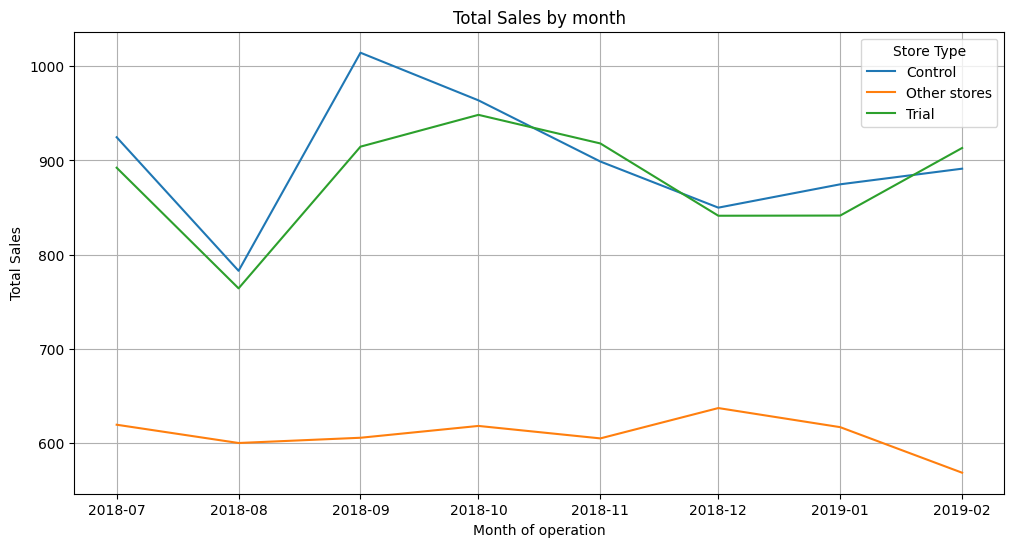

In [163]:
trial_store = 86
control_store = 155
monthly_metrics = monthly_metrics.copy()

# Label store type
monthly_metrics["Store_type"] = monthly_metrics["STORE_NBR"].apply(
    lambda x: "Trial" if x == trial_store else
              "Control" if x == control_store else
              "Other stores"
)

# Group by YEARMONTH and Store_type to get mean sales
pastSales = monthly_metrics.groupby(["YEARMONTH", "Store_type"], as_index=False)["tot_sales"].mean()

# Create a proper date for plotting (1st day of each month)
pastSales["TransactionMonth"] = pd.to_datetime(
    pastSales["YEARMONTH"].astype(str).str[:4] + "-" +
    pastSales["YEARMONTH"].astype(str).str[4:] + "-01"
)

# Filter months before March 2019
pastSales = pastSales[pastSales["YEARMONTH"] < 201903]

# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=pastSales, x="TransactionMonth", y="tot_sales", hue="Store_type")

# Customize plot
plt.title("Total Sales by month")
plt.xlabel("Month of operation")
plt.ylabel("Total Sales")
plt.legend(title="Store Type")
plt.grid(True)
plt.show()

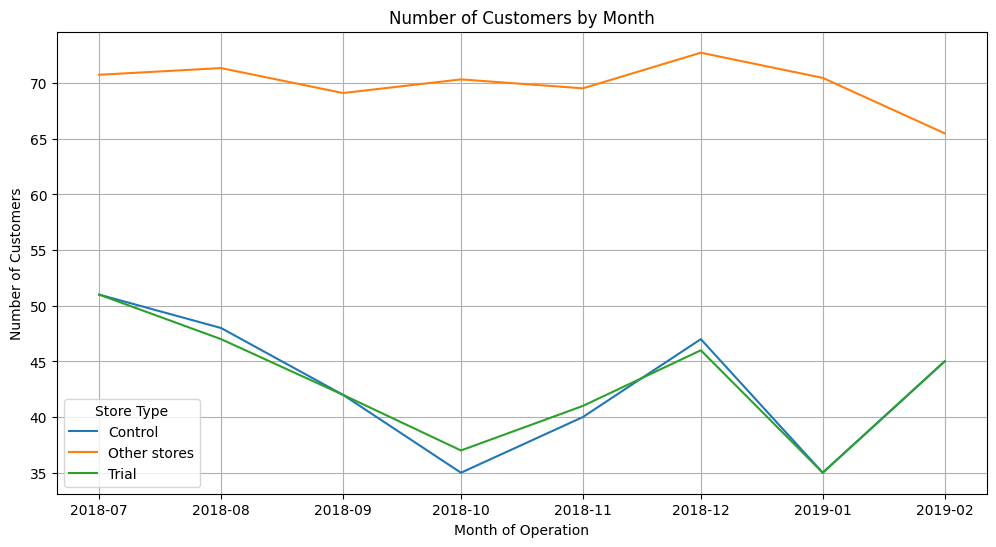

In [164]:
trial_store = 77
control_store = 233
monthly_metrics = monthly_metrics.copy()

# Label store type
monthly_metrics["Store_type"] = monthly_metrics["STORE_NBR"].apply(
    lambda x: "Trial" if x == trial_store else
              "Control" if x == control_store else
              "Other stores"
)

# Group by YEARMONTH and Store_type to get mean of num_customers
pastCust = monthly_metrics.groupby(["YEARMONTH", "Store_type"], as_index=False)["num_customer"].mean()

# Create a proper date for plotting (1st day of each month)
pastCust["TransactionMonth"] = pd.to_datetime(
    pastCust["YEARMONTH"].astype(str).str[:4] + "-" +
    pastCust["YEARMONTH"].astype(str).str[4:] + "-01"
)

# Filter months before March 2019
pastCust = pastCust[pastCust["YEARMONTH"] < 201903]

# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=pastCust, x="TransactionMonth", y="num_customer", hue="Store_type")

# Customize Plot
plt.title("Number of Customers by Month")
plt.xlabel("Month of Operation")
plt.ylabel("Number of Customers")
plt.legend(title="Store Type")
plt.grid(True)
plt.show()

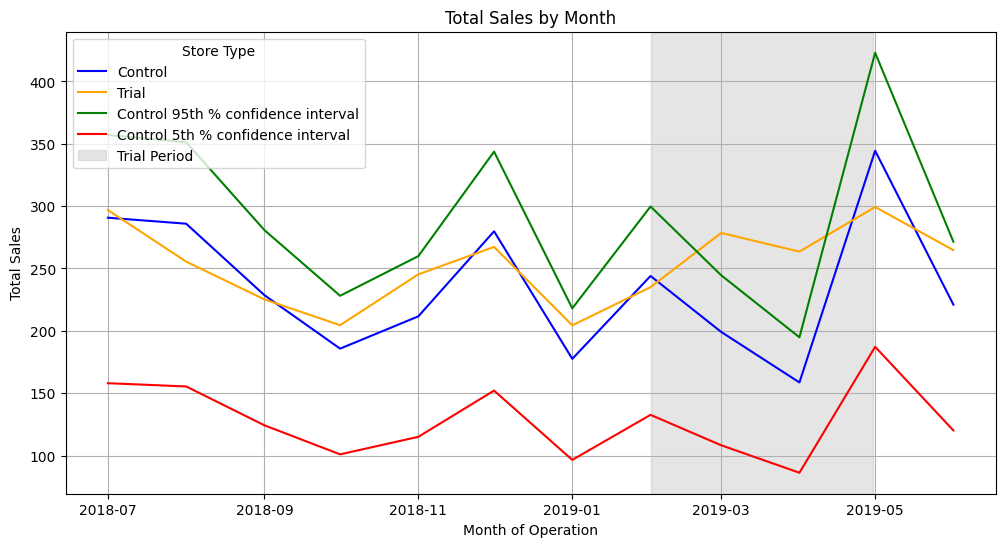

In [165]:
# Add store type
monthly_metrics["Store_type"] = monthly_metrics["STORE_NBR"].apply(
    lambda x: "Trial" if x == trial_store else
              ("Control" if x == control_store else "Other")
)

# Agg avg monthly sales
pastSales = monthly_metrics.groupby(["YEARMONTH", "Store_type"]).agg(
    totSales = ("tot_sales", "mean")
).reset_index()

# Add transaction month
pastSales["TransactionMonth"] = pd.to_datetime(
    pastSales["YEARMONTH"].astype(str) + "01", format="%Y%m%d"
)

# Filter trial and control only
trial_control_sales = pastSales[pastSales["Store_type"].isin(["Trial", "Control"])]

trial_sales = trial_control_sales[trial_control_sales["Store_type"] == "Trial"].reset_index(drop=True)
control_sales = trial_control_sales[trial_control_sales["Store_type"] == "Control"].reset_index(drop=True)
percentageDiff = (trial_sales["totSales"] - control_sales["totSales"]) / control_sales["totSales"]

# Compute standard deviation of percentage diff
stdDev = percentageDiff.std()

# Upper bound (95th percentile)
upper = control_sales.copy()
upper["totSales"] = control_sales["totSales"] * (1 + stdDev)
upper["Store_type"] = "Control 95th % confidence interval"
upper["TransactionMonth"] = control_sales["TransactionMonth"]

# Lower bound (5th percentile)
lower = control_sales.copy()
lower["totSales"] = control_sales["totSales"] * (1 - stdDev * 2)
lower["Store_type"] = "Control 5th % confidence interval"
lower["TransactionMonth"] = control_sales["TransactionMonth"]

# Combine all
trial_assessment = pd.concat([trial_control_sales, upper, lower])
trial_assessment = trial_assessment.loc[:, ~trial_assessment.columns.duplicated()]

# Defibe custom color palette
palette = {
    "Control":"blue",
    "Trial":"orange",
    "Control 95th % confidence interval": "green",
    "Control 5th % confidence interval" : "red"
}

# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=trial_assessment, x="TransactionMonth", y="totSales", hue="Store_type", palette=palette)

# Shade trial period (Feb-Apr 2019)
plt.axvspan(pd.to_datetime("2019-02-01"), pd.to_datetime("2019-04-30"),
            color="grey", alpha=0.2, label="Trial Period")

# Labels and Title
plt.title("Total Sales by Month")
plt.xlabel("Month of Operation")
plt.ylabel("Total Sales")
plt.legend(title="Store Type")
plt.grid(True)
plt.show()

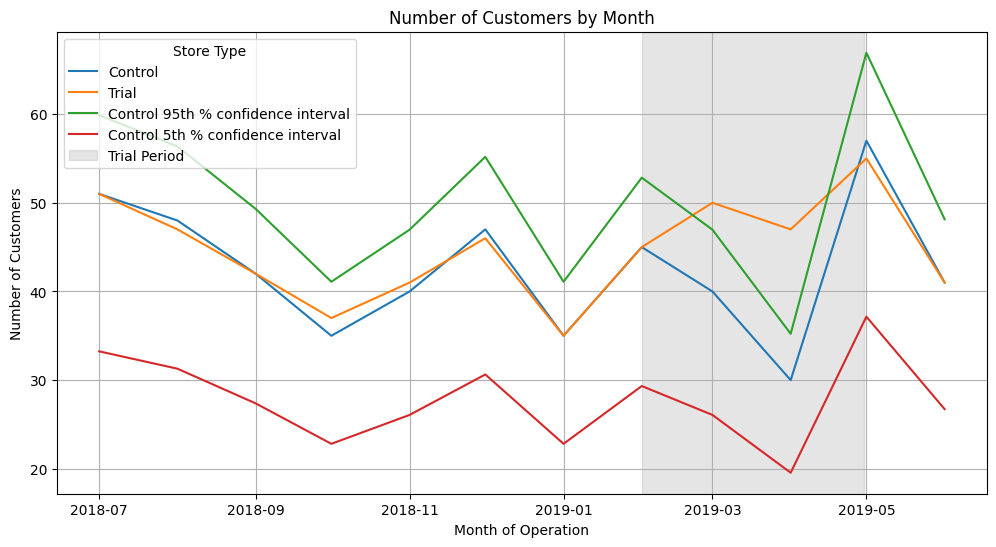

In [166]:
# We'll plot for customers
# Add store type
monthly_metrics["Store_type"] = monthly_metrics["STORE_NBR"].apply(
    lambda x: "Trial" if x == trial_store else
    ("Control" if x == control_store else "Other")
)

# Aggergate avg monthly number of customers
pastCust = monthly_metrics.groupby(["YEARMONTH", "Store_type"]).agg(
    numCust = ("num_customer", "mean")
).reset_index()

# Add transaction month
pastCust["TransactionMonth"] = pd.to_datetime(
    pastCust["YEARMONTH"].astype(str) + "01", format="%Y%m%d"
)

# Filter trial and control only
trial_control_customer = pastCust[pastCust["Store_type"].isin(["Trial", "Control"])]

trial_cust = trial_control_customer[trial_control_customer["Store_type"] == "Trial"].reset_index(drop=True)
control_cust = trial_control_customer[trial_control_customer["Store_type"] == "Control"].reset_index(drop=True)
perecentageDiff = (trial_cust["numCust"] - control_cust["numCust"]) / control_cust["numCust"]

# Compute standard deviation of percentage diff
stdDev = perecentageDiff.std()

# Upper bound (95th percentile)
upper_bound = control_cust.copy()
upper_bound["numCust"] = control_cust["numCust"] * (1 + stdDev)
upper_bound["Store_type"] = "Control 95th % confidence interval"
upper_bound["TransactionMonth"] = control_cust["TransactionMonth"]

# Lower bound (5th percentile)
lower_bound = control_cust.copy()
lower_bound["numCust"] = control_cust["numCust"] * (1 - stdDev * 2)
lower_bound["Store_type"] = "Control 5th % confidence interval"
lower_bound["TransactionMonth"] = control_cust["TransactionMonth"]

# Combine all
trial_assessment = pd.concat([trial_control_customer, upper_bound, lower_bound])
trial_assessment = trial_assessment.loc[:, ~trial_assessment.columns.duplicated()]

# Define custome color palette
palette = {
    "Control":"blue",
    "Trial":"orange",
    "Control 95th % confidence interval": "green",
    "Control 5th % confidence interval" : "red"
}

# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=trial_assessment, x="TransactionMonth", y="numCust", hue="Store_type")

# Shade trial period
plt.axvspan(pd.to_datetime("2019-02-01"), pd.to_datetime("2019-04-30"),
            color="grey", alpha=0.2, label="Trial Period")

# Labels and title
plt.title("Number of Customers by Month")
plt.xlabel("Month of Operation")
plt.ylabel("Number of Customers")
plt.grid(True)
plt.legend(title="Store Type")